In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
ds = load_dataset('multi_news')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

multi_news.py:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

The repository for multi_news contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/multi_news.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train.src.cleaned:   0%|          | 0.00/548M [00:00<?, ?B/s]

train.tgt:   0%|          | 0.00/58.8M [00:00<?, ?B/s]

val.src.cleaned:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

val.tgt:   0%|          | 0.00/7.30M [00:00<?, ?B/s]

test.src.cleaned:   0%|          | 0.00/69.0M [00:00<?, ?B/s]

test.tgt:   0%|          | 0.00/7.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})

In [ ]:
ds['train'][0]

{'document': 'National Archives \n \n Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. \n \n A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. \n \n Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. \n \n Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. economy 

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Adjusted Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase

    # Preserve numbers that are part of key expressions (percentages, monetary values, etc.)
    text = re.sub(r'(?<!\d)\d+(?!\d)', '', text)  # Removes standalone numbers
    text = re.sub(r'(\d+\.\d+%)', r'\1', text)  # Keeps percentages (e.g., "8.2%")
    text = re.sub(r'(\$\d+(?:,\d+)*(?:\.\d+)?)', r'\1', text)  # Keeps monetary values ($100,000)

    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stop words

    return ' '.join(words)

# Load dataset
ds = load_dataset('multi_news')

# Apply preprocessing to the dataset
ds = ds.map(lambda x: {
    'document': preprocess_text(x['document']),
    'summary': preprocess_text(x['summary'])
})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Use TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size for efficiency

# Fit on training documents
X_train = vectorizer.fit_transform(ds['train']['document'])
X_val = vectorizer.transform(ds['validation']['document'])
X_test = vectorizer.transform(ds['test']['document'])

In [ ]:
import numpy as np

In [ ]:
# Create labels: If a document contains a phrase from the summary, label it as important (1)
y_train = np.array([1 if any(word in summary for word in doc.split()) else 0
                     for doc, summary in zip(ds['train']['document'], ds['train']['summary'])])

y_val = np.array([1 if any(word in summary for word in doc.split()) else 0
                   for doc, summary in zip(ds['validation']['document'], ds['validation']['summary'])])

y_test = np.array([1 if any(word in summary for word in doc.split()) else 0
                    for doc, summary in zip(ds['test']['document'], ds['test']['summary'])])

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val)

# Evaluate performance
print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

XGBoost Validation Accuracy: 0.9991106367840626
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       1.00      1.00      1.00      5616

    accuracy                           1.00      5622
   macro avg       1.00      0.58      0.64      5622
weighted avg       1.00      1.00      1.00      5622



In [ ]:
# Precision
precision = precision_score(y_test, y_test_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_test_pred)
print(f"Recall: {recall:.4f}")

# F1-score
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1:.4f}")


Precision: 0.9995
Recall: 0.9998
F1 Score: 0.9996


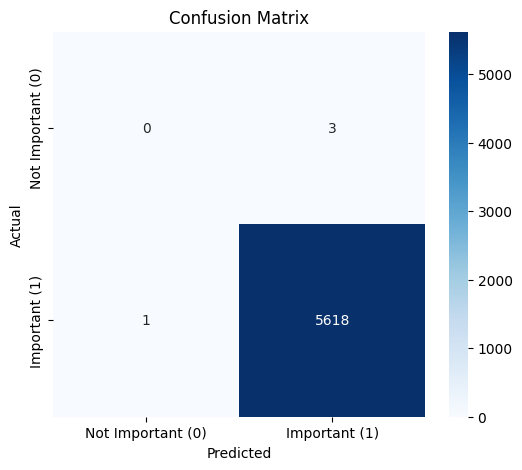

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Not Important (0)', 'Important (1)'],
            yticklabels=['Not Important (0)', 'Important (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(y_test, y_test_pred)
print(f"ROC-AUC Score: {auc_roc:.4f}")

ROC-AUC Score: 0.4999


In [ ]:
!pip install imbalanced-learn

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Confusion Matrix
Under-Sampling,0.898968,1.0,0.898914,0.946767,0.949457,"[[3, 0], [568, 5051]]"
Over-Sampling,0.99662,1.0,0.996619,0.998306,0.998309,"[[3, 0], [19, 5600]]"


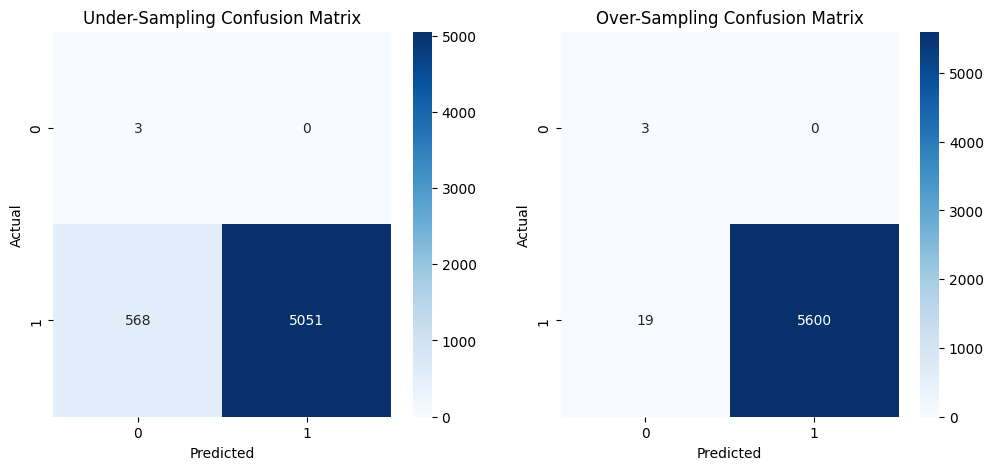

In [ ]:
# Import necessary libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Apply Random Under-Sampling (Solution 1)
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Apply SMOTE (Solution 2)
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Train XGBoost on under-sampled dataset
xgb_under = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_under.fit(X_train_under, y_train_under)

# Train XGBoost on over-sampled dataset
xgb_over = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_over.fit(X_train_over, y_train_over)

# Predict on test set for both models
y_test_pred_under = xgb_under.predict(X_test)
y_test_pred_over = xgb_over.predict(X_test)

# Evaluate metrics
results = {
    "Under-Sampling": {
        "Accuracy": accuracy_score(y_test, y_test_pred_under),
        "Precision": precision_score(y_test, y_test_pred_under),
        "Recall": recall_score(y_test, y_test_pred_under),
        "F1 Score": f1_score(y_test, y_test_pred_under),
        "ROC-AUC": roc_auc_score(y_test, y_test_pred_under),
        "Confusion Matrix": confusion_matrix(y_test, y_test_pred_under)
    },
    "Over-Sampling": {
        "Accuracy": accuracy_score(y_test, y_test_pred_over),
        "Precision": precision_score(y_test, y_test_pred_over),
        "Recall": recall_score(y_test, y_test_pred_over),
        "F1 Score": f1_score(y_test, y_test_pred_over),
        "ROC-AUC": roc_auc_score(y_test, y_test_pred_over),
        "Confusion Matrix": confusion_matrix(y_test, y_test_pred_over)
    }
}

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
from IPython.display import display
display(results_df)

# Plot confusion matrices for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Under-Sampling Confusion Matrix
sns.heatmap(results["Under-Sampling"]["Confusion Matrix"], annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title("Under-Sampling Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Over-Sampling Confusion Matrix
sns.heatmap(results["Over-Sampling"]["Confusion Matrix"], annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title("Over-Sampling Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()